This script train a shallow FNN to approximated the discrete-time dynamics model of the lunar lander.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# read data

filepath = '../Data/'
DATA_dict = dict()
num_traj = 40
for i in range(num_traj):
    num = i+1;
    if num >= 10:
        str_num = str(num) # no leading zero
    else:
        str_num = '0'+str(num) # add leading zero
    filename = 'trajdata_'+str_num+'.csv'
    with open(filepath+filename, 'r') as f:
        # remove top row, and store the rest in dictionary
        DATA_dict[i] = np.genfromtxt(f, dtype='f4', delimiter=',', skip_header=1)

In [9]:
# Define model parameters
bv = 5.         
bo = 11.         
m = 10.          
g = 9.8
I = 10.83333333

In [19]:
# We select the first trajectory as the training set

# P, V, dV
P = DATA_dict[0][:,1:4]
F = DATA_dict[0][:,4]
tau = DATA_dict[0][:,5]
T = DATA_dict[0][:,0]
Dt = 0.0025
V = (P[1:,:]-P[:-1,:])/Dt
A = np.array([[-bv/m,0,0],[0,-bv/m,0],[0,0,bo/I]])

dV = V@A.T
dV[:,0] = dV[:,0] + np.multiply(-np.sin(P[:-1,2])/m, F[:-1])
dV[:,1] = dV[:,1] + np.multiply(np.cos(P[:-1,2])/m, F[:-1]) - g
dV[:,2] = dV[:,2] + tau[:-1]/I

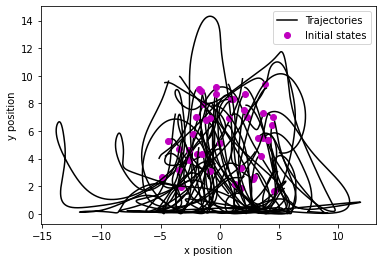

In [3]:
# Plot all position trajectories

for i in range(num_traj-1):
    curr_traj = DATA_dict[i]
    plt.plot(curr_traj[:,1],curr_traj[:,2],'k-') # plot trajectory path
    plt.plot(curr_traj[0,1],curr_traj[0,2],'mo') # plot initial position

# Show legend on last trajectory
curr_traj = DATA_dict[num_traj-1]
plt.plot(curr_traj[:,1],curr_traj[:,2],'k-',label='Trajectories')
plt.plot(curr_traj[0,1],curr_traj[0,2],'mo',label='Initial states')

plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.show()

In [4]:
# Add 10% Gaussian noise to data

percentage = 0.10

N = 30
for i in range(N):
    stdd = np.std(DATA_dict[i][:,1:], axis=0)
    for j in range(stdd.shape[0]):
        noise = np.random.normal(0, stdd[j], DATA_dict[i][:,j+1].size) * percentage
        DATA_dict[i][:,j+1] = DATA_dict[i][:,j+1] + noise

## Learn from one trajectory

In [5]:
# We select the first trajectory as the training set
X = DATA_dict[0][:-1,1:]
Y = DATA_dict[0][1:,1:4]

In [7]:
# define the keras model 5-10-10-5 configuration,
# relu activation for the hidden layer
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=5, activation = 'relu',use_bias=False),
    tf.keras.layers.Dense(10, activation = 'relu',use_bias=False),
    tf.keras.layers.Dense(3,use_bias=False)])

In [8]:
# compile the keras model
net.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [9]:
# fit the keras model on the dataset
net.fit(X, Y, epochs=100, batch_size=10,verbose=2)

Epoch 1/100
396/396 - 1s - loss: 25.9036 - mse: 25.9036 - 584ms/epoch - 1ms/step
Epoch 2/100
396/396 - 0s - loss: 3.3025 - mse: 3.3025 - 309ms/epoch - 780us/step
Epoch 3/100
396/396 - 0s - loss: 1.8112 - mse: 1.8112 - 308ms/epoch - 777us/step
Epoch 4/100
396/396 - 0s - loss: 1.2543 - mse: 1.2543 - 264ms/epoch - 667us/step
Epoch 5/100
396/396 - 0s - loss: 0.9326 - mse: 0.9326 - 275ms/epoch - 695us/step
Epoch 6/100
396/396 - 0s - loss: 0.7949 - mse: 0.7949 - 270ms/epoch - 682us/step
Epoch 7/100
396/396 - 0s - loss: 0.6343 - mse: 0.6343 - 277ms/epoch - 700us/step
Epoch 8/100
396/396 - 0s - loss: 0.5411 - mse: 0.5411 - 267ms/epoch - 675us/step
Epoch 9/100
396/396 - 0s - loss: 0.4952 - mse: 0.4952 - 274ms/epoch - 691us/step
Epoch 10/100
396/396 - 0s - loss: 0.4940 - mse: 0.4940 - 285ms/epoch - 720us/step
Epoch 11/100
396/396 - 0s - loss: 0.4026 - mse: 0.4026 - 328ms/epoch - 828us/step
Epoch 12/100
396/396 - 0s - loss: 0.4029 - mse: 0.4029 - 266ms/epoch - 672us/step
Epoch 13/100
396/396 - 0s

In [10]:
# We select the last trajectory as the test set
X_test = DATA_dict[39][:-1,1:]
Y_test = DATA_dict[39][1:,1:4]

In [11]:
loss_test = net.evaluate(X_test,Y_test,batch_size=X_test.shape[0],verbose=0)
print('The MSE on the test set is',loss_test[0])

The MSE on the test set is 4.071476459503174


In [12]:
Y_pred = net(X_test, training=False).numpy()

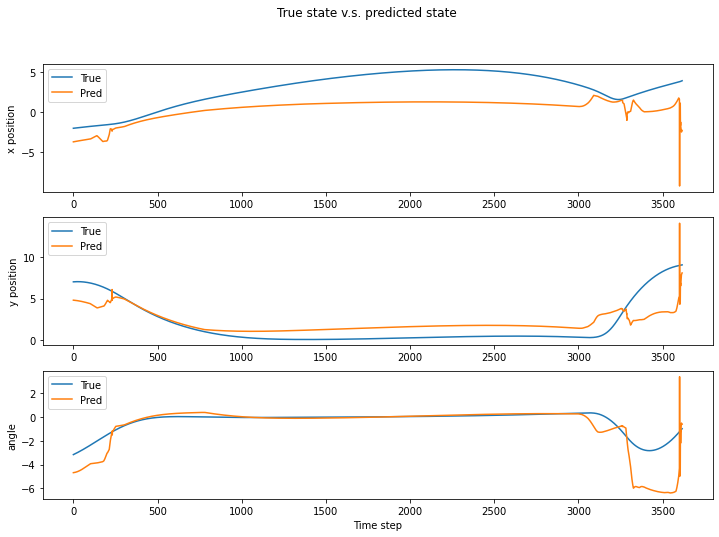

In [13]:
T = range(Y_test.shape[0])
fig, axs = plt.subplots(3,figsize=[12,8])
fig.suptitle('True state v.s. predicted state')
axs[0].plot(T,Y_test[:,0], T,Y_pred[:,0])
axs[1].plot(T,Y_test[:,1], T,Y_pred[:,1])
axs[2].plot(T,Y_test[:,2], T,Y_pred[:,2])
axs[0].set_ylabel('x position')
axs[1].set_ylabel('y position')
axs[2].set_ylabel('angle')
axs[2].set_xlabel('Time step')
axs[0].legend(['True','Pred'])
axs[1].legend(['True','Pred'])
axs[2].legend(['True','Pred'])

In [33]:
fig.savefig('FNN-one-traj-learn.png')

## Learn from multiple trajectories

In [52]:
# We select the first 30 trajectory as the training set
X = np.zeros((0,5))
Y = np.zeros((0,3))
N = 30
for i in range(N):
    X = np.vstack((X,DATA_dict[i][:-1,1:]))
    Y = np.vstack((Y,DATA_dict[i][1:,1:4]))

In [53]:
# define the keras model 5-10-10-5 configuration,
# relu activation for the hidden layer
net2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=5, activation = 'relu',use_bias=False),
    tf.keras.layers.Dense(10, activation = 'relu',use_bias=False),
    tf.keras.layers.Dense(3,use_bias=False)])

In [54]:
# compile the keras model
net2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [55]:
# fit the keras model on the dataset
net2.fit(X, Y, epochs=50, batch_size=100,verbose=2)

Epoch 1/50
891/891 - 1s - loss: 15.9555 - mse: 15.9555 - 953ms/epoch - 1ms/step
Epoch 2/50
891/891 - 1s - loss: 3.2357 - mse: 3.2357 - 629ms/epoch - 706us/step
Epoch 3/50
891/891 - 1s - loss: 0.9410 - mse: 0.9410 - 607ms/epoch - 681us/step
Epoch 4/50
891/891 - 1s - loss: 0.4160 - mse: 0.4160 - 647ms/epoch - 726us/step
Epoch 5/50
891/891 - 1s - loss: 0.2591 - mse: 0.2591 - 641ms/epoch - 720us/step
Epoch 6/50
891/891 - 1s - loss: 0.2007 - mse: 0.2007 - 670ms/epoch - 752us/step
Epoch 7/50
891/891 - 1s - loss: 0.1821 - mse: 0.1821 - 662ms/epoch - 743us/step
Epoch 8/50
891/891 - 1s - loss: 0.1646 - mse: 0.1646 - 670ms/epoch - 752us/step
Epoch 9/50
891/891 - 1s - loss: 0.1693 - mse: 0.1693 - 647ms/epoch - 727us/step
Epoch 10/50
891/891 - 1s - loss: 0.1522 - mse: 0.1522 - 603ms/epoch - 677us/step
Epoch 11/50
891/891 - 1s - loss: 0.1400 - mse: 0.1400 - 659ms/epoch - 740us/step
Epoch 12/50
891/891 - 1s - loss: 0.1541 - mse: 0.1541 - 697ms/epoch - 782us/step
Epoch 13/50
891/891 - 1s - loss: 0.12

In [56]:
# We select the last 10 trajectory as the test set
X_test = np.zeros((0,5))
Y_test = np.zeros((0,3))

X_test = np.zeros((0,5))
Y_test = np.zeros((0,3))
M = 10
for i in range(M):
    X_test = np.vstack((X_test,DATA_dict[39-i][:-1,1:]))
    Y_test = np.vstack((Y_test,DATA_dict[39-i][1:,1:4]))

In [57]:
loss_test = net2.evaluate(X_test,Y_test,batch_size=X_test.shape[0],verbose=0)
print('The MSE on the test set is',loss_test[0])

The MSE on the test set is 0.007239190395921469


In [43]:
test = 31
X_test_last = DATA_dict[test][:-1,1:]
Y_test_last = DATA_dict[test][1:,1:4]
Y_pred = net2(X_test_last, training=False).numpy()

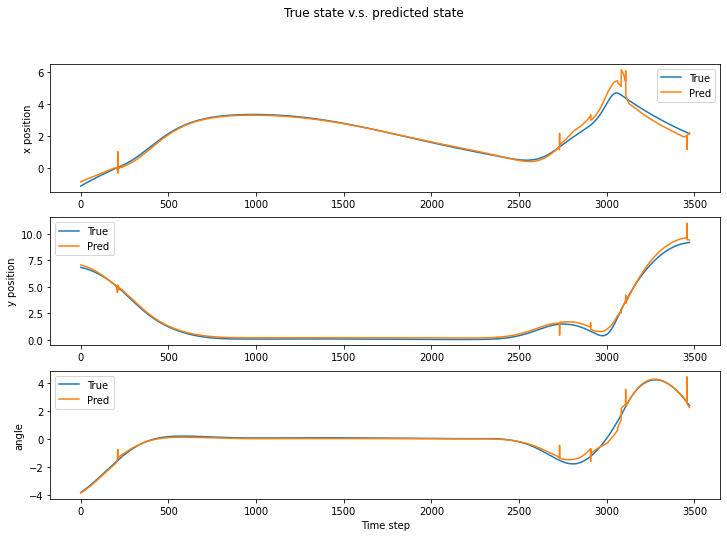

In [44]:
T = range(Y_test_last.shape[0])
fig, axs = plt.subplots(3,figsize=[12,8])
fig.suptitle('True state v.s. predicted state')
axs[0].plot(T,Y_test_last[:,0], T,Y_pred[:,0])
axs[1].plot(T,Y_test_last[:,1], T,Y_pred[:,1])
axs[2].plot(T,Y_test_last[:,2], T,Y_pred[:,2])
axs[0].set_ylabel('x position')
axs[1].set_ylabel('y position')
axs[2].set_ylabel('angle')
axs[2].set_xlabel('Time step')
axs[0].legend(['True','Pred'])
axs[1].legend(['True','Pred'])
axs[2].legend(['True','Pred'])

In [47]:
fig.savefig('FNN-multi-traj-learn.png')